In [1]:
import pandas as pd
import numpy as np
import warnings
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)
from script import create_time_series
from fsrs_optimizer import Optimizer, Trainer

warnings.filterwarnings("ignore")

lr: float = 4e-2
n_epoch: int = 5
batch_size: int = 512
verbose: bool = False
optimizer = Optimizer()

file = "../dataset/24.csv"

dataset = pd.read_csv(file)
dataset = create_time_series(dataset).reset_index()
optimized_list = []
dry_run_list = []
pretrain_list = []
testsets = []

max_pow = np.floor(np.log2(len(dataset)))

indexes = [2**i for i in range(int(max_pow) + 1)]
print(indexes)

for max_index in indexes:
    train_set = dataset.loc[:max_index].copy()
    test_set = dataset.loc[max_index : min(max_index + 2000, len(dataset) - 1)].copy()
    testsets.append(test_set)
    optimizer.define_model()
    dry_run_list.append(optimizer.init_w.copy())

    optimizer.S0_dataset_group = (
        train_set[train_set["i"] == 2]
        .groupby(by=["r_history", "delta_t"], group_keys=False)
        .agg({"y": ["mean", "count"]})
        .reset_index()
    )
    _ = optimizer.pretrain(dataset=train_set, verbose=verbose)
    pretrain_list.append(optimizer.init_w.copy())

    try:
        trainer = Trainer(
            train_set,
            None,
            optimizer.init_w,
            n_epoch=n_epoch,
            lr=lr,
            batch_size=batch_size,
        )
        optimized_list.append(trainer.train(verbose=verbose))
    except Exception as e:
        print(e)
        optimized_list.append(optimizer.init_w.copy())

[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]
Training data is inadequate.
Training data is inadequate.
Training data is inadequate.
Training data is inadequate.


In [2]:
from fsrs_optimizer import Collection, power_forgetting_curve, rmse_matrix
from collections import defaultdict
from sklearn.metrics import log_loss

rmses = defaultdict(list)
loglosses = defaultdict(list)
for i, (w1, w2, w3, testset) in enumerate(zip(optimized_list, pretrain_list, dry_run_list, testsets)):
    for j, w in enumerate((w1, w2, w3)):
        my_collection = Collection(w)
        stabilities, difficulties = my_collection.batch_predict(testset)
        testset["p"] = power_forgetting_curve(testset["delta_t"], stabilities)
        rmse = rmse_matrix(testset)
        rmses[j].append(rmse)
        logloss = log_loss(testset["y"], testset["p"])
        loglosses[j].append(logloss)


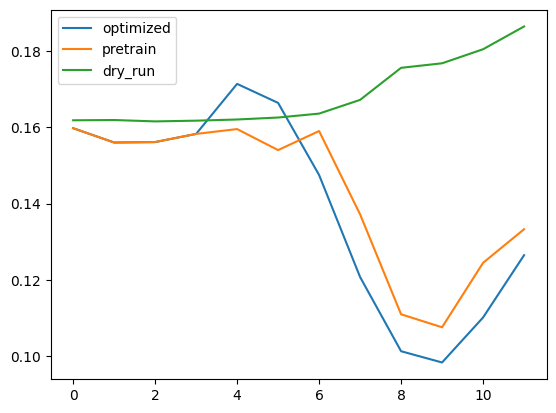

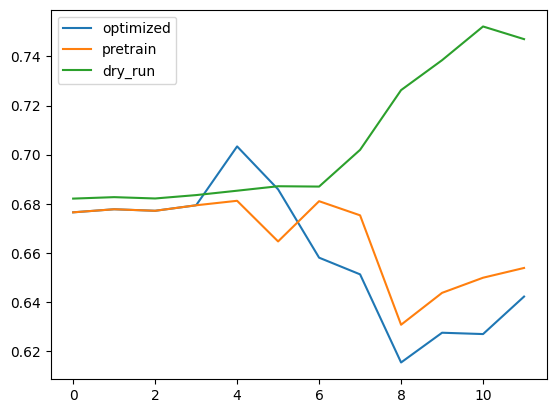

In [3]:
import matplotlib.pyplot as plt

plt.plot(rmses[0], label="optimized")
plt.plot(rmses[1], label="pretrain")
plt.plot(rmses[2], label="dry_run")
plt.legend()
plt.show()

plt.plot(loglosses[0], label="optimized")
plt.plot(loglosses[1], label="pretrain")
plt.plot(loglosses[2], label="dry_run")
plt.legend()
plt.show()